# Fission chains and Monte Carlo methods

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name='Mikkel'

In this datalab we are going to cover two topics:

1. Fission chain events: we are going to experiment with random "neutron trees" to have a more fundamental understanding of criticality. Then we will learn how to estimate the $k_{eff}$ of a system with Monte Carlo methods.
2. Monte Carlo particle transport: in the previous datalab we have started to write functions to sample random collision sites, random angles, now we will go one step further, end put together our functions into a particle transport solver for a simple homogeneous geometry. Notice this part of the datalab is in a separate file called '5b-FixedSourceMC'.


## Experiment 1

You remember from the lectures that after a fission event a random number of neutrons emerge (the $\nu$ value). First we will plot this distribution for thermal fission of U-235 with the `plt.bar()` function of matplotlib. Then you also remember from the previous datalab that such a discrete distribution can be sampled with the `np.random.choice()` function which requires a list of events, and a list giving the probabilities of these events. We will use this to sample some random number of neutrons from the discrete distribution of $\nu$.

The possible outcomes are given in list `nu` and the related probabilities in list `pnu`.

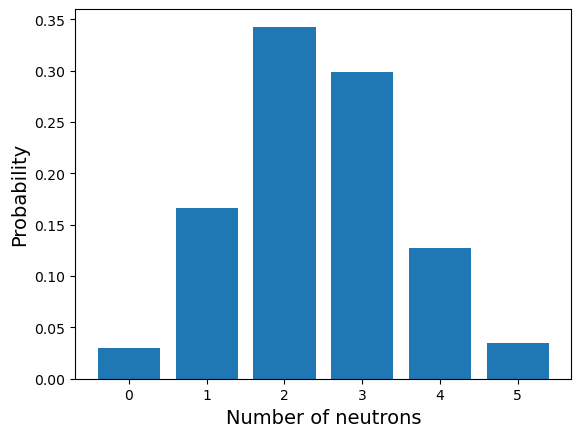

In [5]:
import numpy as np
import matplotlib.pyplot as plt

nu=[0,1,2,3,4,5]
pnu=[0.0296,0.1665,0.3427,0.2987,0.1275,0.035]

plt.figure()
#use plt.bar() to plot a bar histogram of the distribution
plt.bar(nu, pnu)
plt.xlabel('Number of neutrons', fontsize=14)
plt.ylabel('Probability',fontsize=14)
plt.show()

Now we will sample 1000 random $\nu$ values from this distribution. Type `?np.random.choice` to see the documentation, and find out how to input the sample size. Visualize your "empirical" distribution with `plt.hist`.

In [22]:
?np.random.choice

In [77]:
nu

[0, 1, 2, 3, 4, 5]

In [82]:
np.random.choice(nu, p=pnu)

2

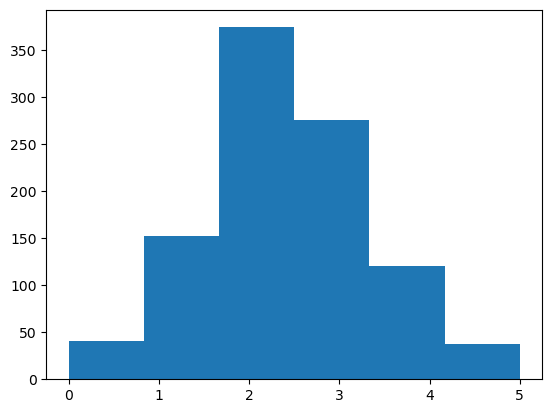

In [31]:
N=1000

nus = np.random.choice(nu, N, p=pnu)

plt.figure()
#use plt.hist() to see the empirical distribution of nus. Change the number of bins if you think needed!
plt.hist(nus, bins=6)
plt.show()

## Experiment 2

We are going to generate random neutron trees now! A neutron has a probability `p` that it enters a reaction which can lead to the birth of new neutrons (ie. a fission reaction). Then, there is a certain probability that in the reaction more neutrons are created. We will describe this discrete probability distributions
as in Experiment 1.

Below you find the `Neutron()` and `Tree()` classes. You do not need to modify these (but you are of course welcome to read through the code), they are only included in the notebook for transparency. First just execute the next code cell.

In [32]:
class Neutron(object):
    """A neutron object
    
    Attributes
    ----------
    x : float
        x-coordinate of neutron on the plot (which is basically the index of the generation it belongs to)
    y : float
        y-coordinate of neutron on the plot (this is a rather arbitrary number)
    dead : bool
        Bool to decide whether the neutron have died in a reaction not producing further neutrons
    parent : Neutron() object
        The parent of the neutron
    """
    def __init__(self,x=0.0,y=0.0,parent=None):
        self.id=None
        self.x=x
        self.y=y
        self.dead=False
        self.parent=parent

class Tree(object):
    """Random neutron tree object. Attributes are not documented here. 
    
    Parameters
    ----------
    p : float
        Probability that a neutron survives
    nufiss : tuple
        Is the probability distribution of the number of neutrons created in fission.
        Should be a tuple of two lists (first giving the number of neutrons after fission
        and the second giving the probabilities)
    nstart : int
        Number of orignal neutrons
    ngen : int
        Number of generations to follow
    yshift : float
        distance of neutrons on the plot in the y direction.
    """
    def __init__(self,p,nufiss,nstart,ngen,yshift=0.5):
        self.p=p
        self.nufiss=nufiss
        self.nstart=nstart
        self.ngen=ngen
        self.yshift=yshift
        self.generations=[[] for _ in range(ngen)]
        self.generations[0]=[Neutron() for i in range(nstart)]
        
    def run(self):
        """Function to generate random neutron trees"""
        for i in range(self.ngen-1):
            for neutron in self.generations[i]:
                r=np.random.random()
                if self.p>r: #then it survives
                    newBorn=np.random.choice(nufiss[0],p=nufiss[1])
                    if newBorn==0: #then essentially it dies
                        neutron.dead=True
                    else:
                        for _ in range(newBorn):
                            newNeutron=Neutron(x=i+1,parent=neutron) 
                            #x is essentially the related generation's number
                                                                     
                                #if one would assume the time also x could reflect that
                            self.generations[i+1].append(newNeutron)
                else: #then it dies
                    neutron.dead=True

    def plot(self,showDead=True,aligned=False,out=None):
        """Function to plot random neutron trees"""
        plt.figure()
        for batch in self.generations[:-1]:
            #in the last batch all neutrons are still alive, so we don't plot them
            for i,neutron in enumerate(batch): 
                if aligned:
                    neutron.y=i*self.yshift-len(batch)*self.yshift/2
                else:
                    neutron.y=i*self.yshift
                    
                if showDead and neutron.dead:
                    plt.plot(neutron.x,neutron.y,'rx')
                    if neutron.parent is not None:
                        plt.annotate('', xy=(neutron.parent.x,neutron.parent.y), 
                                 xytext=(neutron.x,neutron.y), arrowprops=dict(arrowstyle='<-'))
                if (not neutron.dead):
                    plt.plot(neutron.x,neutron.y,'ko')
                    if neutron.parent is not None:
                        plt.annotate('', xy=(neutron.parent.x,neutron.parent.y), 
                                 xytext=(neutron.x,neutron.y), arrowprops=dict(arrowstyle='<-'))
        plt.yticks([])
        if out is not None:
            plt.savefig(out,dpi=300)
        plt.show()

Now we will create instances of `Tree()`. We will pass parameters when initiating an object to input the probability that a neutron enters a reaction leading to a fission event (`p`), the distribution of the number of new neutrons from fission (`nufiss`), the number of neutron generations to follow (`ngen`) and the number of initiating neutrons (`nstart`). Then we call the method `Tree.run()` to generate a random neutron tree, and finally we call the method `Tree.plot()` to visualize the tree. The plotting method can have parameters, for example the bool `aligned` describes whether the tree should be centered, and the bool `showDead` controls whether neutrons not giving birth to further neutrons are plotted.

Run the cell below several times, while changing the probability `p`. 

Try to investigate (only visually, you do not need to record actual numbers): 
- When does the tree die out, how does the number of neutrons change from generation to generation? 
- When does the number of neutrons diverge? Do the same `p` value always result in similar trees? 
- How could you define the multiplication factor $k$, and the criticality for these trees? 

Write few sentences about your findings in the cell below

Some combinations of interest are: 
- medium `p` values with medium `nstart` values (eg. the default setting below)
- low `p` values with large (<100) `nstart` values
- large `p` values (cca. 0.7) with low `nstart` values.
- you can modify `nufiss` as well, to define some other distribution. For example what happens if always a fixed number of neutrons are created?

**Note #1** Of course this simple model is a very abstract representation of a fission chain reaction in a nuclear reactor. It allows us to have an understanding of the random nature of chain reactions. What is clearly missing from the model is the time it takes for a neutron to reach its final destination from its birth location. This would mean that neutrons of the same generations would infact not be synchronized in time.

**Note #2** If the number of neutrons are diverging (for example due to high `p`), then the computation time also diverges. Therefore, when running the code with large `p` and for a large number of generations, the computation might never end, and the plotting of a lot of neutrons might become problematic! You can always interrupt the kernel (above in the menu you see a black rectangle ie. "stop" sign, or select Interrupt under Kernel), if this happens.

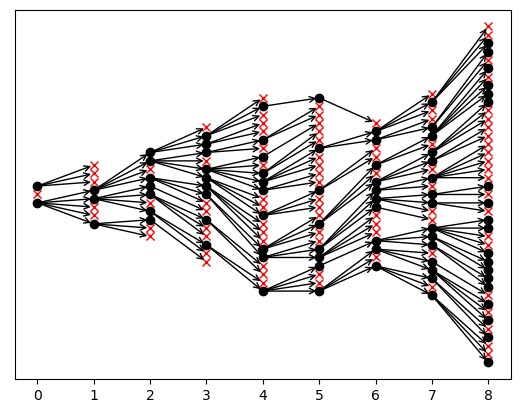

In [59]:
nu=[0,1,2,3,4,5]
pnu=[0.0296,0.1665,0.3427,0.2987,0.1275,0.035]
nufiss=(nu,pnu)

p = 0.5
tree=Tree(p,nufiss,ngen=10,nstart=3)
tree.run()
tree.plot(aligned=True,showDead=True)

Change this cell to your conclusion!

## Experiment 3

From Experiment 2 we learnt a very important lesson about the simulation of fission chains: simulating supercritical systems is not straightforward, since in such systems the number of neutrons diverges. The terminology refers to this set of problems as "Monte Carlo Eigenvalue calculation", which means, Monte Carlo calculations intended to estimate the k-effective. 

The solution to this problem is to estimate the k-effective in cycles or batches (which is somewhat related to a neutron generation), and finally take an average of the k-effective estimate in each batch (see p37 of https://mcnp.lanl.gov/pdf_files/la-ur-16-29043.pdf). This means that we launch $N$ neutrons in a batch and we follow all of them. When they reach there location of death (either capture or fission) we sample how many neutrons they give birth to. Then from the number of new neutrons and the number of original neutrons we can estimate the k-effective. Then in the next batch we launch again $N$ neutrons. We repeat this until the uncertainty on the average of the k-effective estimates is acceptable. 

Now we will make such an estimation of the k-effective in our simple model. The parameters are the same as before (`p` is the probability of a neutron entering fission, and the number of emerging neutrons is given by a distribution). We will implement the following algorithm (given in pseudo code) to estimate k-effective:

```
    keffs = []
    for all batches:
        Nnew = 0
        for all neutrons in batch:
            if neutron enters fission:
                increment Nnew with the random number of neutrons emerging from fission
        k-effective estimate of batch = Nnew/(neutrons per batch)
        append k-effective estimate to the list keffs
    final k-effective estimate is mean(keffs)
```

Estimate the k-effective for couple of `p` values, try to find when the system is critical. Do you have an intuition what should the value of `p` be for a critical system?

**Note #1**: we provided the code of two plots. The first one will plot the estimated k-effective for each batch. The second one calculates the rolling average of the k-effective values. This plot will highlight how the final k-effective estimate converges to its real value.

**Note #2**: in our simple model the location of the fission events is not tracked, however in a proper geometry one would also keep track of that: one would save the fission sites in a list called the "bank". Then, in the subsequent batches the new neutron source locations would be sampled from the bank. With this it can be ensured that source locations are sampled according to the spatial dependence of the fission rate. 


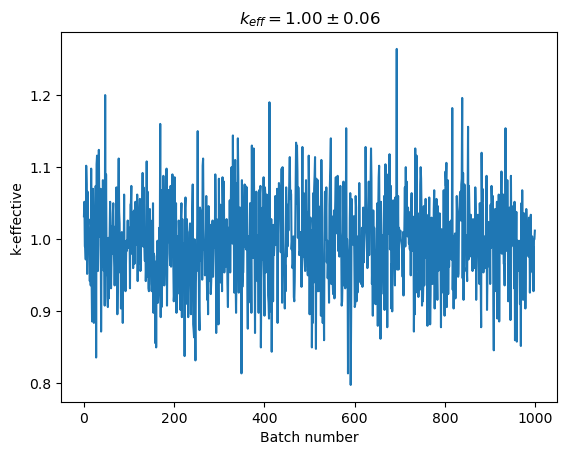

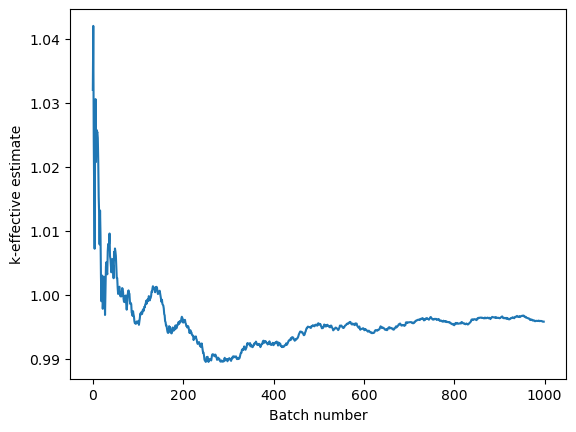

In [90]:
nu=[0,1,2,3,4,5]
pnu=[0.0296,0.1665,0.3427,0.2987,0.1275,0.035]

p=0.41

Nbatches=1000 #number of batches to be simulated
npbatch=500   #number of neutrons per batch

keffs = []
for i in range(Nbatches):
    Nnew = 0
    for i in range(npbatch):
        fission = np.random.choice([False, True], p=[1-p,p])
        if fission:
            Nnew += np.random.choice(nu, p=pnu)
    k_eff = Nnew/npbatch
    keffs.append(k_eff)
    

keff=np.mean(keffs)

plt.figure()
plt.plot(keffs)
plt.title(r'$k_{eff}=%.2f \pm %.2f$'%(np.mean(keffs),np.std(keffs)))
plt.xlabel('Batch number')
plt.ylabel('k-effective')
plt.show()

keffestimate=[np.mean(keffs[:i]) for i in range(1,len(keffs))]
plt.figure()
plt.plot(keffestimate)
plt.ylabel('k-effective estimate')
plt.xlabel('Batch number')
plt.show()



## Experiment 4

It is very common that we would like to find the critical configuration of a reactor core, for example for a certain geometry we would like to know the boron content of the modarator for which the core will be critical. Such tasks are root finding/optimization/minimization problems. 

We will use now the `scipy.optimize.newton` method to find the probability `p` in the previous experiments at which our system is critical (although you might have already figured it out). Minimization is not a trivial task, espescially when the function which needs to be minimized includes noise (as the case is for our problem, since we saw the k-effective estimate does have uncertainties). We advise you to read further on the documentation of the various optimization algorithms.

Take your previously developed code to estimate k-effective from Experiment 3, and place it in a function `keffestimator()`. You do not need to have the $\nu$ distribution, the number of batches and the number of neutrons per batch as an input parameter for the function, you can "hard-code" them inside the function (although usually that is not advised).

Inspect how the `scipy.optimize.newton` method calls your function calls your function with different `p` values, and slowly converges to the critical value. 

Conclude what is the critical value of `p`, and what is your theoretical expectation?

**Note**: the root finder has a tolarance value, and one could also set the maximum number of iterations. However, for this case we could only achieve a very low accuracy if we increased the Number of batches and number of neutrons. You do not need to increase the accuracy, the goal of this experiment is just to understand the principals of minimizing this function.

In [89]:
def keffestimator(p):
    """Function to estimate the k-eff of a simple system
    
    Parameters
    ----------
    p : float
        Probability that a neutron enters a fission reaction.
    """
    Nbatches=1000 #number of batches to be simulated
    npbatch=500  
    keffs = []
    for i in range(Nbatches):
        Nnew = 0
        for i in range(npbatch):
            fission = np.random.choice([0,1], p=[1-p,p])
            if fission == 1:
                Nnew += np.random.choice(nu, p=pnu)
        k_eff = Nnew/npbatch
        keffs.append(k_eff)

    keff=np.mean(keffs)
    
    return keff-1.0
    

from scipy.optimize import newton
p_initialguess = 0.5
res = newton(keffestimator,p_initialguess,tol=1e-3)
print('Final critical p value found to be {}'.format(res))

Final critical p value found to be 0.41030928902852387


Change this cell to your conclusion!

# Experiment 5

We will now put together a Monte Carlo particle transport simulation for a Fixed-source problem based on our functions written during the previous datalab. You will need to open the notebook ´5b-FixedSourceMC.ipynb´.